## Latent Semantic Analysis

Latent Semantic Analysis (also called Latent Semantic Indexing) is the process of applying PCA to a tf-idf term-document matrix. What we get, in the end, is clusters of terms that presumably reflect a topic. Each document will get a score for each topic, with higher scores indicating that the document is relevant to the topic. Documents can pertain to more than one topic.

LSA is handy when your corpus is too large to topically annotate by hand, or when you don't know what topics characterize your documents. It is also useful as a way of creating features to be used in other models.

Let's try it out! Once again, we'll use the gutenberg corpus. This time, we'll focus on comparing paragraphs within Emma by Jane Austen

In [1]:
# Import libraries:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
import re
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /Users/vilandao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/vilandao/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [2]:
# Reading the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')

# Processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    para=[re.sub(r'--','',word) for word in para] #removing the double-dash from all words
    emma_paras.append(' '.join(para)) #forming each paragraph into a string and adding it to the list of strings.

print(emma_paras[0:5])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .', "She was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of her sister ' s marriage , been mistress of his house from a very early period ."]


In [5]:
# Define tfidfvectorizer:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=123)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

# Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

# Splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=123)

# Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

# Number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]
    
#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('')
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: But at last there seemed a perverse turn ; it seemed all at once as if he were more afraid of its being a bad sore throat on her account , than on Harriet ' s  more anxious that she should escape the infection , than that there should be no infection in the complaint .

Tf_idf vector: {'escape': 0.35120659230647405, 'turn': 0.32238320694189937, 'complaint': 0.37625602722408696, 'throat': 0.36214891705659447, 'sore': 0.36214891705659447, 'anxious': 0.3082760967744069, 'afraid': 0.2911961276743497, 'bad': 0.2857419390466859, 'harriet': 0.17257230514763916, 'account': 0.27855292186624075}


In [6]:
# Dimensionality reduction with TruncatedSVD:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Our SVD data reducer. We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)

for i in range(5):
    print('')
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 44.63615902900558

Component 0:
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
Oh !      0.999622
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
Name: 0, dtype: float64

Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                                                                                                                                                                                                                                                                                         0.628719
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                 

## Sentence similarity

We can also look at how similar various sentences are to one another. For example, here are the similarity scores (as a heatmap) of the first 10 sentences in the training set:

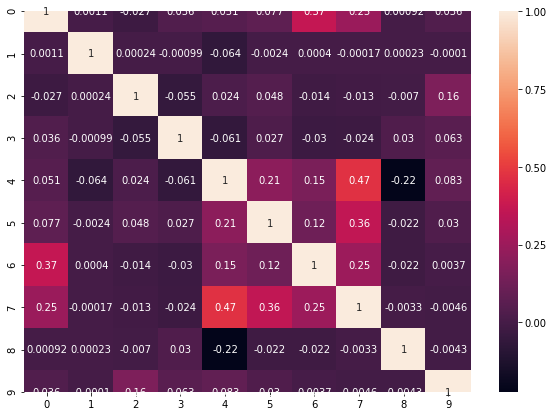

Key:

0 He looked with smiling penetration ; and , on receiving no answer , added , " _She_ ought not to be angry with you , I suspect , whatever he may be . To that surmise , you say nothing , of course ; but confess , Emma , that you did want him to marry Harriet ."

1 " Ah !

2 " You have some news to hear , now you are come back , that will rather surprize you ."

3 " I have made a most wretched discovery ," said he , after a short pause . " I have been here a week to - morrow  half my time .

4 " Well !

5 But at last there seemed a perverse turn ; it seemed all at once as if he were more afraid of its being a bad sore throat on her account , than on Harriet ' s  more anxious that she should escape the infection , than that there should be no infection in the complaint .

6 Harriet , who was standing at some distance , and with face turned from her , did not immediately say any thing ; and when she did speak , it was in a voice nearly as agitated as Emma ' s .

7 " Harriet !"

8 "

In [7]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]

#Making a plot
plt.figure(figsize=(10,7))
sns.heatmap(sim_matrix,yticklabels=range(10), annot=True)
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print('')
    print(i,sim_matrix.index[i])

## Test LSA on test set:

In [8]:
# Apply LSA model to the test set. Does it identify similar sentences for components 0 through 4?
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)

for i in range(5):
    print('')
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 44.63615902900558

Component 0:
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
" Oh !    0.999622
Name: 0, dtype: float64

Component 1:
Mrs . Weston said no more ; and Emma could imagine with what surprize and mortification she must be returning to her seat .                                                                                                               0.578833
" Emma knows I never flatter her ," said Mr . Knightley , " but I meant no reflection on any body .                                                                                                                                       0.578683
Emma knew that she had , but would not own it ; and Mr . Elton warmly added ,                                                                                                                                    

## Tweak LSA

In [15]:
print('Changes: Decrease max_df to 0.3 (drop words in more than 30% of paragraphs), min_df =5, and correction factor to L1')

vectorizer = TfidfVectorizer(max_df=0.3, # drop words that occur in more than 30% the paragraphs
                             min_df=5, # only use words that appear at least 5 times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l1', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Changes: Decrease max_df to 0.3 (drop words in more than 30% of paragraphs), min_df =5, and correction factor to L1
Number of features: 799
Percent variance captured by all components: 70.97488467020383


In [16]:
#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)

for i in range(5):
    print('')
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Component 0:
" There does , indeed , seem as little to tempt her to break her resolution at present ," said Mrs . Weston , " as can well be ; and while she is so happy at Hartfield , I cannot wish her to be forming any attachment which would be creating such difficulties on poor Mr . Woodhouse ' s account .    0.999926
" So much the better  or so much the worse : I do not know which .                                                                                                                                                                                                                                         0.999926
CHAPTER XV                                                                                                                                                                                                                                                                                                 0.999926
" But , my dear papa , you are no friend to matrimony ; and th